In [1]:
import h5py
import numpy as np
import keras
from keras.models import Sequential
from keras.layers import Dense  
from keras import backend as K
from sklearn.model_selection import train_test_split
import sklearn.metrics as metrics
import pandas as pd
import tables
import matplotlib.pyplot as plt
import tensorflow as tf
import preprocessing
import matplotlib as mpl

In [2]:
model = keras.models.load_model('./models/final_model/')
batch_size = 100

2022-10-01 20:30:53.467382: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-01 20:30:53.493033: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-01 20:30:53.493412: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-01 20:30:53.493910: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

In [3]:
dataPath = '/home/WindowsDrive/Shared/Top_Tagging_Data/test.h5'
with h5py.File(dataPath, 'r') as data:

    npDataLabels = np.array(data['labels'])

    npDataWeights = np.array(data['weights'])

    jetVars = {key: data[key][...] for key in data.attrs.get('jet')}
    
    hlDataArr = {key: data[key][...] for key in data.attrs.get('hl')}

    hlKeys = data.attrs.get('hl')

processed_dict = preprocessing.high_level(hlDataArr)
processed_df = pd.DataFrame(processed_dict)

jetVarsArr = [val for val in jetVars.values()]
jetVarsDf = pd.DataFrame(np.stack(jetVarsArr, axis=-1))

data_train, data_test, labels_train, labels_test, weights_train, weights_test, jetVars_train, jetVars_test = train_test_split(processed_df, npDataLabels, npDataWeights, jetVarsDf, test_size=0.33, random_state=69, shuffle=True)

test_data_set = tf.data.Dataset.from_tensor_slices((data_test, labels_test, weights_test)).batch(batch_size)

## Now to start analysing

In [4]:
testPreds = model.predict(test_data_set)

8198/8198 [==============================] - 13s 2ms/step


In [5]:
print(len(labels_test))

819759


In [6]:
data_test_new = data_test.copy()
data_test_new['labels'] = labels_test
data_test_new['weights'] = weights_test
data_test_new['predictions'] = testPreds
data_test_new['jet_pt'] = jetVars_test[0]
data_test_new['jet_eta'] = jetVars_test[1]
data_test_new['jet_phi'] = jetVars_test[2]
data_test_new['jet_m'] = jetVars_test[3]


In [13]:
binary_predictions = []
for i in data_test_new['predictions']:
    if i <= 0.5:
        binary_predictions.append(0)
    else:
        binary_predictions.append(1)

data_test_new['binary_predictions'] = np.array(binary_predictions)


In [14]:
renameDict = {i: hlKeys[i] for i in range(15)}
data_test_new.rename(renameDict, axis='columns', inplace=True)

In [15]:
sigIndices = data_test_new['labels'] == 1
bkgIndices = data_test_new['labels'] == 0

In [34]:
conf_matrix = metrics.confusion_matrix(data_test_new['labels'], data_test_new['binary_predictions'], labels=[1,0])

In [35]:
print((conf_matrix[0,0]+conf_matrix[1,1]) / ())

[[367092  42453]
 [ 80269 329945]]


In [36]:
metrics.confusion_matrix([1,1,1,1,0,0,0,0], [1,1,1,1,0,0,0,1], labels=[1,0])

array([[4, 0],
       [1, 3]])

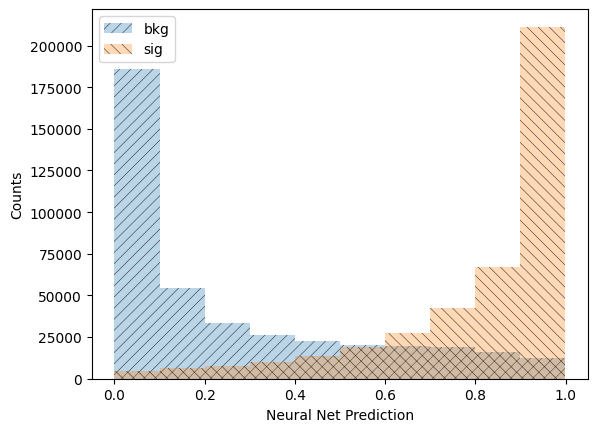

In [9]:
plt.figure()
plt.xlabel('Neural Net Prediction')
plt.ylabel('Counts')

bkgHist = plt.hist(data_test_new['predictions'][bkgIndices], bins=10, weights=data_test_new['weights'][bkgIndices], label='bkg', alpha=0.3, hatch='///')
sigHist = plt.hist(data_test_new['predictions'][sigIndices], bins=10, weights=data_test_new['weights'][sigIndices], label='sig', alpha=0.3, hatch='\\\\\\')

# bkgHistNN = plt.hist(backgroundVals["predictions"], bins=5, weights=backgroundVals["weights"],label="backgrounds", range=[0,1], alpha=0.6)
# sigHistNN = plt.hist(signalVals["predictions"], bins=5, weights=signalVals["weights"],  label=r"$H\rightarrow \tau\tau$ signal",range=[0,1], alpha=0.6)

# bkgHistNN = plt.hist(backgroundVals['predictions'], bins=5, label="backgrounds", range=[0,1], alpha=0.6)
# sigHistNN = plt.hist(signalVals['predictions'], bins=5, label="signals", range=[0,1], alpha=0.6)

plt.legend()
mpl.rcParams['hatch.linewidth'] = 0.3

# plt.yscale('log')
plt.show() 

In [25]:
print(data_test_new.columns)

Index(['fjet_Tau1_wta', 'fjet_Tau2_wta', 'fjet_Tau3_wta', 'fjet_Tau4_wta',
       'fjet_Split12', 'fjet_Split23', 'fjet_ECF1', 'fjet_ECF2', 'fjet_ECF3',
       'fjet_C2', 'fjet_D2', 'fjet_Qw', 'fjet_L2', 'fjet_L3', 'fjet_ThrustMaj',
       'labels', 'weights', 'predictions', 'jet_pt', 'jet_eta', 'jet_phi',
       'jet_m'],
      dtype='object')


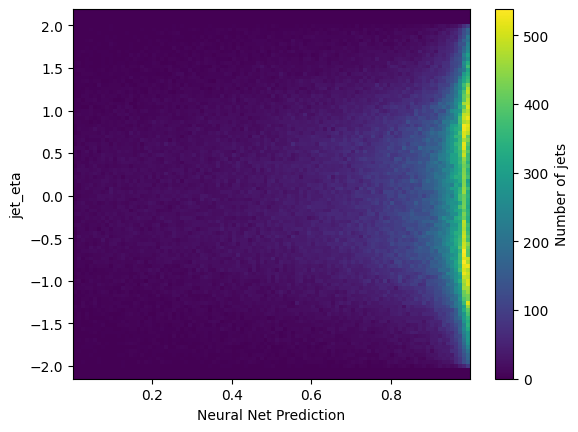

In [17]:
plt.figure()
plt.xlabel('Neural Net Prediction')
plt.ylabel('jet_eta')

plt.hist2d(data_test_new['predictions'][sigIndices], data_test_new['jet_eta'][sigIndices], bins=[100, 100])
plt.colorbar(label='Number of jets')
plt.show()

In [21]:
correct_sig_preds = data_test_new[sigIndices][data_test_new['predictions'][sigIndices] >= 0.5]

In [24]:
percent_correct_sig_preds = len(correct_sig_preds)/len(data_test_new[sigIndices])
print(percent_correct_sig_preds)

0.8703683355919374


sig efficiency: 
$$ \epsilon_{sig} = \frac{N^{tagged}_{sig}}{N^{total}_{sig}} $$

bkg rejection:
$$ \frac{1}{\epsilon_{bkg}} = \frac{N^{total}_{bkg}}{N^{tagged}_{bkg}} $$

In [11]:
fpr, tpr, thresholds = metrics.roc_curve(data_test_new['labels'], data_test_new['predictions'])

/tmp/ipykernel_40689/3512539685.py:1: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr, 1 / fpr)


Text(0.5, 0, 'Signal efficiency')

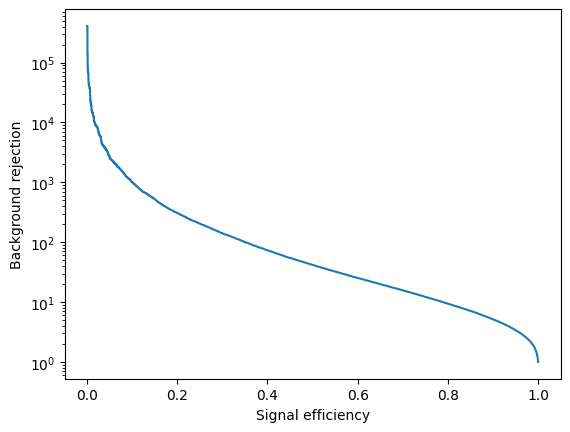

In [14]:
plt.plot(tpr, 1 / fpr)
plt.yscale('log')
plt.ylabel('Background rejection')
plt.xlabel('Signal efficiency')